# FAST HI观测规划助手`obshelper`示例1：多波束OTF扫描观测

by astroR2 2025/5/10

* 示例1将介绍如何使用本程序包规划常见模式的扫描观测，适用于`MultibeamOTF`模式。

* 天顶角与合适的观测时间的检查请见另一个例子。

* 注意：本程序与FAST官方无关，纯个人开发使用，请仔细检查输出结果，如有错误概不负责。请务必先详细阅读[FAST观测常见问题](https://fast.bao.ac.cn/cms/article/147/)与[用户帮助文档](https://fast.bao.ac.cn/cms/article/80/)。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import hiviewer as hv
import os

from obshelper.opt_source import OptSource
from obshelper.utils.util import line_set

from astropy.coordinates import SkyCoord
from astropy import units as u

## M31的MultibeamOTF观测

这里只是举个例子，并不是真实的观测。

In [2]:
# 后面会在此fits图像的wcs基础上画图，射电的、光学的任意波段都可以
m0 = hv.FitsPic('./data/M31_DSS2 Red_0-opt.fits')

Showing image.


<WCSAxes: >

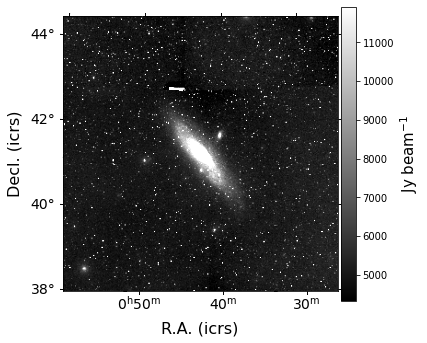

In [3]:
m0.plot_slice(per_vmin_max=0.98)

In [4]:
# M31的坐标
ra, dec = 10.684799, 41.269076

# 使用OTF时间计算器
from obshelper.MultiBeamOTF_Time import MultiOTFcalculator

## 横扫
这里的例子并没有把M31全覆盖上，只是示例

**注意**这里输入的`diff_ra`只是RA的差，不是角距离(未考虑$\cos \delta$)

In [5]:
# 这里简单的设置RA扫描范围3*60分钟，DEC 21.66*3角分
otc1 = MultiOTFcalculator(ra, dec, diff_ra = 3 * 60, diff_dec = 21.66 * 3)
otc1.get_startend()
# '-'代表横扫，21.66角分是多波束旋转的波束间隔，扫描速度15角秒/秒
otc1.input_OTF_para(direction = '-', scan_gap = 21.66, scan_speed = 15)
otc1.calculate_time()

MultiBeam OTF, direction:  -
Scan gap: 21.66 arcmin
Scan speed: 15.0 arcsec / s
Scan 4.0 times along -, switch 3.0 times.
Need total 3150.0 s = 52.5 min.


Showing image.
Sample time: 0.5 s
Rotation angle: 23.4 deg
Total times (include switching 10 min) 1.042 hours
Total times (not include switching 10 min) 0.875 hours


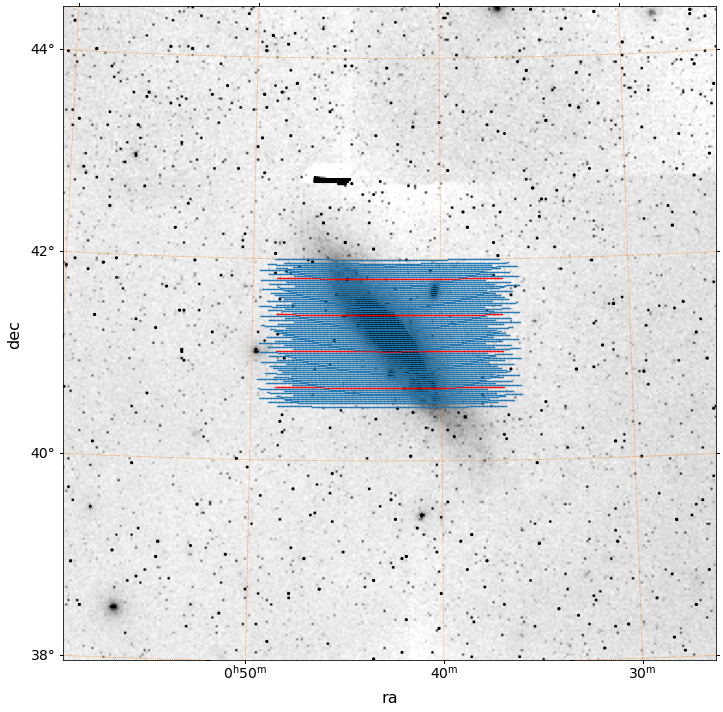

In [6]:
ax = m0.plot_slice(cmap = 'gray_r', per_vmin_max= 0.98, colorbar=False, figsize = (12, 10),  )
ax.grid(color = 'C1',ls = ':')

# 采样时间0.5秒，gap表示隔5隔数据点画上去一个，防止点太乱
otc1.show_footprints(ax, m0, sample_time = 0.5, 
                    gap = 5, ms = 1, alpha = 1, color = f'C0', Print = True)

# 观测时间
total_time1 = otc1.tot_time.to(u.hour).value + 10 / 60
total_time2 = otc1.tot_time.to(u.hour).value

print(f"Total times (include switching 10 min) {total_time1:.3f} hours")
print(f"Total times (not include switching 10 min) {total_time2:.3f} hours")
plt.show()

In [7]:
# OTF的起始点和终止点
s = otc1.start
e = otc1.end
s, e

(<SkyCoord (ICRS): (ra, dec) in deg
     (9.184799, 40.727576)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (12.184799, 41.810576)>)

In [8]:
m0.data.shape

(300, 300)

Showing image.


/home/xuc/.local/lib/python3.9/site-packages/hiviewer-1.3.0-py3.9.egg/hiviewer/core.py:245: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Sample time: 0.5 s
Rotation angle: 23.4 deg


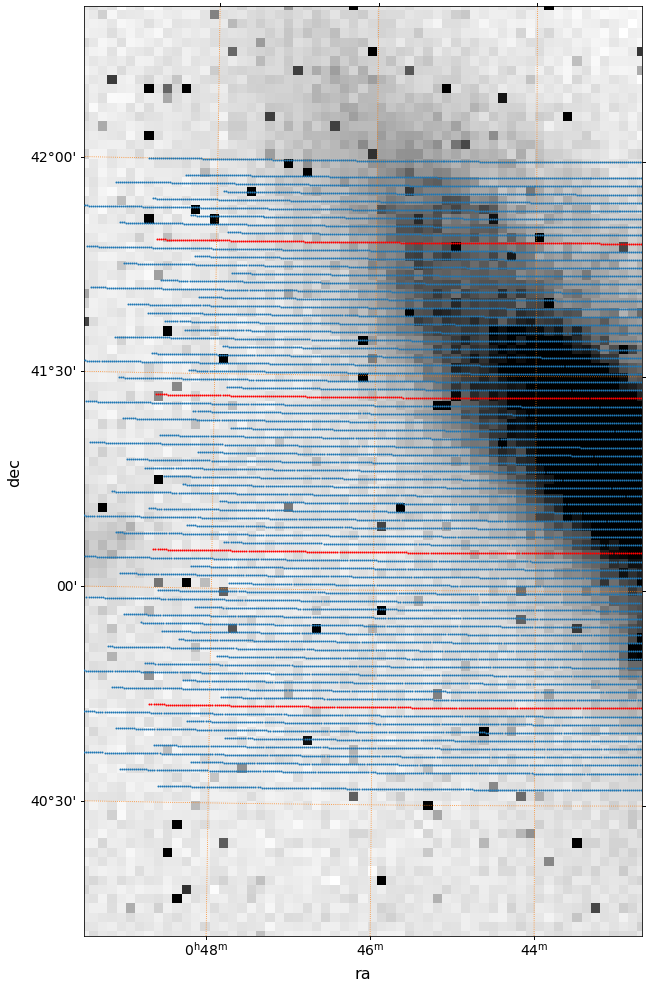

In [9]:
# 检查scan gap有无设置错误，都是等间隔的
ax = m0.plot_slice(cmap = 'gray_r', per_vmin_max= 0.98, colorbar=False, figsize = (10, 20),  
                  xylim=(90, 150, 100, 200))
ax.grid(color = 'C1',ls = ':')

otc1.show_footprints(ax, m0, sample_time = 0.5, 
                    gap = 3, ms = 2, alpha = 1, color = f'C0', Print = True)

In [10]:
# 观测天区面积，加减0.038度是最上面和最下面采样不足的gap
from obshelper.utils.util import area
A = area(s.ra.value, e.ra.value, np.min(otc1.dec_all)+ 0.038, np.max(otc1.dec_all)- 0.038)
A

<Quantity 3.12752814 deg2>

## 竖扫
刚才我们是沿着dec方向的扫描，FAST也可以纵向编织。切换时间短一点。

In [11]:
np.cos(dec * u.deg)

<Quantity 0.75162024>

In [12]:
# 这里简单的设置RA方向覆盖21.66*3角分，DEC 1*60角分
otc2 = MultiOTFcalculator(ra - 21.66/60/2, dec, diff_ra = 21.66 * 3 / np.cos(dec * u.deg), diff_dec = 2 * 60, )
otc2.get_startend()
# '|'代表竖扫，21.66角分是多波束旋转的波束间隔，扫描速度15角秒/秒
otc2.input_OTF_para(direction = '|', scan_gap = 21.66, scan_speed = 15)

MultiBeam OTF, direction:  |
Scan gap: 21.66 arcmin
Scan speed: 15.0 arcsec / s


你会发现设置的是21.66x3角分，但是实际转了4次，完整覆盖了4个波束间隔，这是因为由于cos dec，diff_ra增大了，diff_ra / scan_gap约等于4。也因此看起来M31中心并不在OTF区域的中心，如果你觉得难受，可以把输入的源的ra整体移动下。比如我移动了- 21.66/60/2度。

In [13]:
scanTimes = np.round(otc2.diff_ra / otc2.scan_gap + 1.0)
switchTimes = np.round(otc2.diff_ra / otc2.scan_gap)
scanTimes, switchTimes, otc2.diff_ra / otc2.scan_gap

(<Quantity 5.>, <Quantity 4.>, <Quantity 3.99137733>)

Showing image.
Sample time: 0.5 s
Rotation angle: 53.4 deg
renew obs time and center
Scan 6.0 times along |, switch 5.0 times.
Need total 3150.0 s = 52.5 min.
Total times (include switching 10 min) 1.042 hours
Total times (not include switching 10 min) 0.875 hours


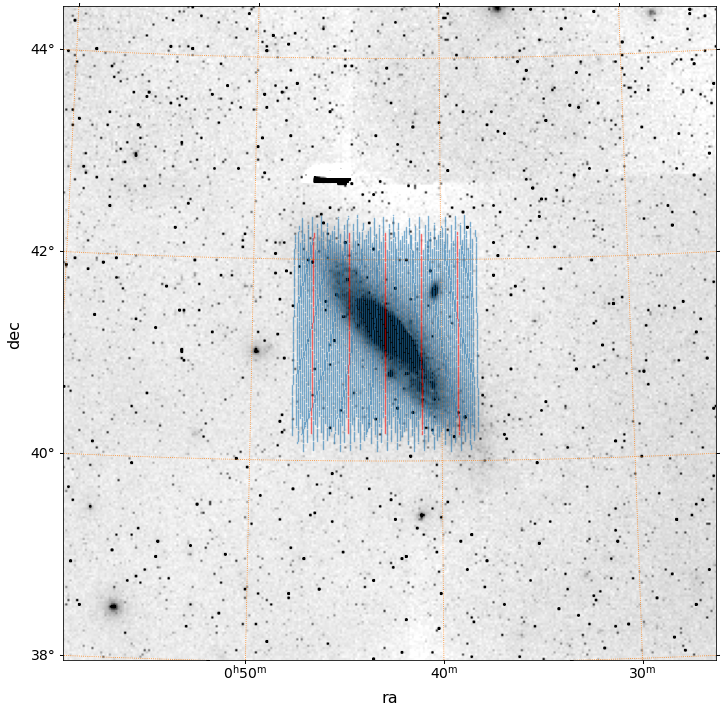

In [14]:
ax = m0.plot_slice(cmap = 'gray_r', per_vmin_max= 0.98, colorbar=False, figsize = (12, 10),  )
ax.grid(color = 'C1',ls = ':')

# 采样时间0.5秒，gap表示隔5隔数据点画上去一个，防止点太乱
otc2.show_footprints(ax, m0, sample_time = 0.5, 
                    gap = 5, ms = 1, alpha = 0.5, color = f'C0', Print = True)

# 观测时间
total_time1 = otc2.tot_time.to(u.hour).value + 10 / 60
total_time2 = otc2.tot_time.to(u.hour).value

print(f"Total times (include switching 10 min) {total_time1:.3f} hours")
print(f"Total times (not include switching 10 min) {total_time2:.3f} hours")
plt.show()

也可以把footprint都画一起

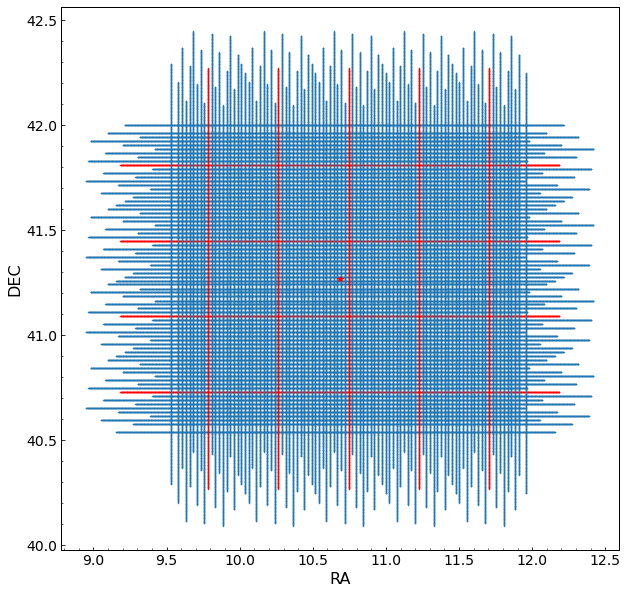

In [15]:
otc = otc1
fig, ax = plt.subplots(figsize = (10, 10))

for j in np.arange(0, 19, 1):

    c = 'r' if j == 0 else f'C0'
    px, py = otc.ra_all[j], otc.dec_all[j]
    ax.plot(px, py, '.', c = c, ms = 1, alpha = 1)

otc = otc2

for j in np.arange(0, 19, 1):

    c = 'r' if j == 0 else f'C0'
    px, py = otc.ra_all[j], otc.dec_all[j]
    ax.plot(px, py, '.', c = c, ms = 1, alpha = 1)

ax.set_xlabel('ra')    
ax.set_ylabel('dec') 

ax.plot(ra, dec, 'r*')
line_set(ax, xlabel = 'RA', ylabel = 'DEC', legend=False,
            )

plt.show()

你所见到的格子不均匀来自波束的位置在平面内旋转后产生的角秒量级偏差，可以忽略。

In [16]:
## 生成FAST要求的txt格式，也可以复制粘贴手动提交

header = ["#Source Name", "Observation Mode", "RA(hh:mm:ss.ss)", "DEC(dd:mm:ss.s)", "StartRA(hh:mm:ss.ss)", "StartDEC(dd:mm:ss.s)", "EndRA(hh:mm:ss.ss) ", "EndDEC(dd:mm:ss.s)",
         "time(sec)"]

df = pd.DataFrame(columns=header)
def format_radec(pos):
    ra1 = pos.ra.to_string(unit = u.hourangle, sep = ':', precision=2, pad = True)
    dec1 = pos.dec.to_string(unit = u.degree, sep = ':', precision=1, alwayssign = True)
    return ra1, dec1

k = 0
for otc in [otc1, otc2]:

    ra_, dec_ = format_radec(otc.center)
    ra_start, dec_start = format_radec(otc.start)
    ra_end, dec_end = format_radec(otc.end)

    t = otc.tot_time.to(u.second).value
    df.loc[k] = [f"M31_test_{k+1}", "MultiBeamOTF", ra_, dec_, ra_start, dec_start, ra_end, dec_end, t]
    # 修改源名称
    k += 1

In [17]:
df

,#Source Name,Observation Mode,RA(hh:mm:ss.ss),DEC(dd:mm:ss.s),StartRA(hh:mm:ss.ss),StartDEC(dd:mm:ss.s),EndRA(hh:mm:ss.ss),EndDEC(dd:mm:ss.s),time(sec)
0,M31_test_1,MultiBeamOTF,00:42:44.35,+41:16:08.7,00:36:44.35,+40:43:39.3,00:48:44.35,+41:48:38.1,3150.0
1,M31_test_2,MultiBeamOTF,00:42:58.67,+41:16:08.7,00:39:08.13,+40:16:08.7,00:46:49.21,+42:16:08.7,3150.0


In [18]:
# 保存时不需要最后一列时间列
df[df.keys()[:-1]].to_csv('./obsfile/M31_test_MultibeamOTF.txt', sep='|', index = False)